# IMGEP-UGL

In [30]:
from abc import *
import numpy as np
import scipy.stats
import itertools

%matplotlib notebook
import matplotlib.pyplot as plt

import sys
sys.path.append("../src")

import actors
import armballs
import representation_pytorch

import torch
from torch.autograd import Variable

import time

from tqdm import tqdm_notebook as tqdm
from IPython.core.debugger import set_trace
from IPython.display import clear_output

In [3]:
import scipy.stats    

def discretized_entropy(X_s, n_bins=30):
    n_samples, n_dim = X_s.shape
    histp, _ = np.histogramdd(X_s, bins=n_bins, range=np.array([[-1] * n_dim, [1] * n_dim]).T)
    histp = histp.ravel() / histp.sum()
    return scipy.stats.entropy(histp)

def nb_explored_cells(X_s, n_bins=30):
    n_samples, n_dim = X_s.shape
    histp, _ = np.histogramdd(X_s, bins=n_bins, range=np.array([[-1] * n_dim, [1] * n_dim]).T)
    return len(np.where(histp>0)[0])

# Arm Balls

<IPython.core.display.Javascript object>


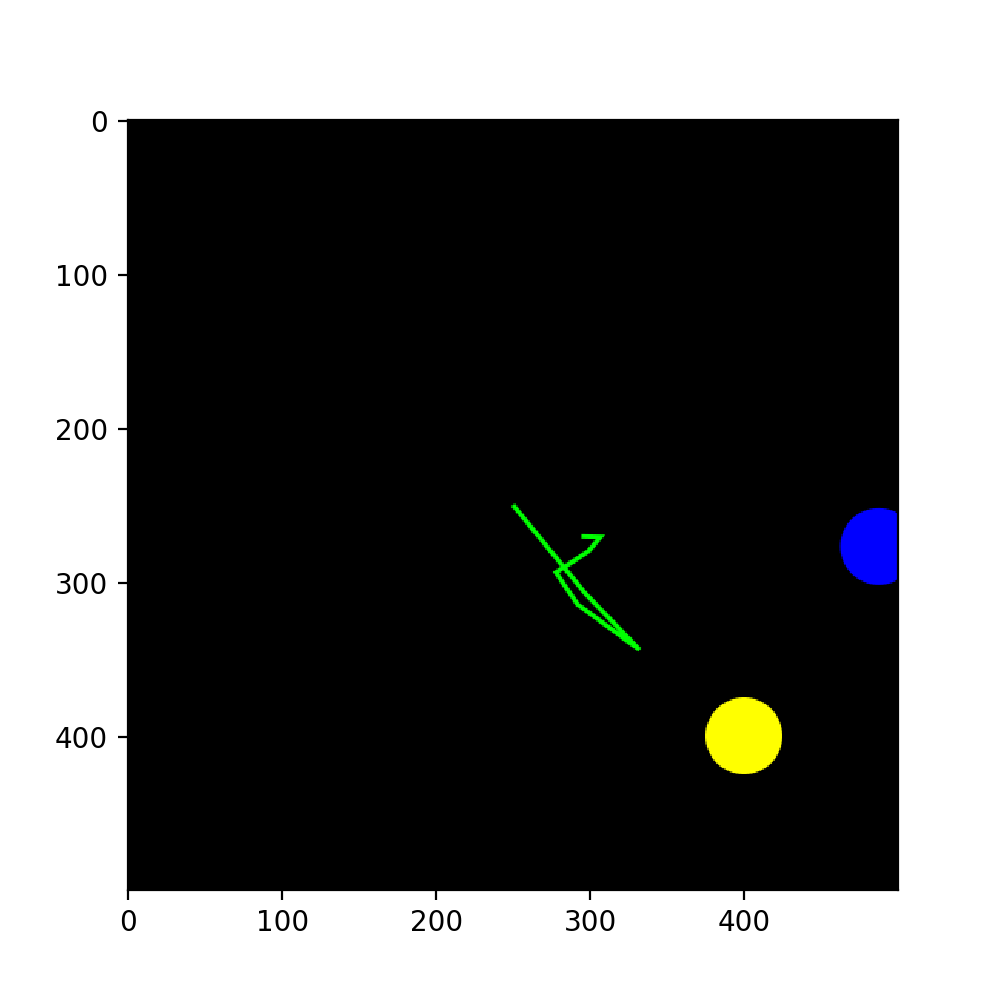

In [9]:
a = armballs.MyArmBallsObserved(arm_lengths=np.array([0.3, 0.2, 0.2, 0.1, 0.1, 0.05, 0.05]), object_size=0.1,
                                distract_size=0.1, distract_noise=0.1, n_rbf=7, sdev=10., n_timesteps=50,
                                render=True, rgb=True)
a.reset()
# A random motor command
a.act(np.random.randn(len(a.action_space)))

### Example of an experiment

In [20]:
# Configuration for environment
env_config = dict()
env_config.update({'arm_lengths': np.array([0.3, 0.2, 0.2, 0.1, 0.1, 0.05, 0.05]),
                   'object_size': 0.1, 'distract_size': 0.1, 'distract_noise': 0.1,
                   'n_rbf': 7, 'sdev': 10, 'n_timesteps': 50, 'render_arm': False,
                   'width': 64, 'height': 64, 'rgb': True, 'render': False})

In [37]:
# Random Parameterization Experiment
n_exploration_iterations = 2000
a = actors.RandomParameterizationExploration(static_env=armballs.MyArmBalls, **env_config)
a.reset()
a.act(n_iter=n_exploration_iterations, render=False)

In [38]:
# We compute the number of explored cells
nb_explored_cells(np.array(a.outcomes_states))

41

In [39]:
# MGE Vae experiment
n_bootstrap = 400
n_exploration_iterations = 1600
# Disentangled representation
model_path = '../weights/ArmBalls_rgb_BallDistract'
# Entangled representation
# model_path = '../weights/ArmBalls_rgb_BallDistract_ent'
# We observe the ball moving (probably a scientist)
a = armballs.ArmBallsRenderer(**env_config)
a.reset()

training_images = []
for i in range(1000):
    state = np.random.uniform(-1, 1, a.observation_space.shape[0])
    a.act(observation=state)
    training_images.append(a.rendering)
training_images = np.array(training_images)

# We perform Bootstrap
a = actors.RandomParameterizationExploration(static_env=armballs.MyArmBallsObserved, **env_config)
a.reset()
a.act(n_iter=n_bootstrap, render=False)

# We perform AGE-UGL
b = actors.ActiveGoalExplorationUgl(static_env=armballs.MyArmBallsObserved,
                                    representation=representation_pytorch.PytorchBetaVAERepresentation,
                                    n_latents=10, beta=1, initial_epochs=0,
                                    interest_model='normal', n_explore=4, explo_ratio=0.1,
                                    n_modules=5, explo_noise_sdev=0.05, win_size=1000, **env_config)
b.load_representation(actions=a.actions, outcomes=a.outcomes, outcomes_states=a.outcomes_states,
                      outcomes_train=training_images, model_path=model_path)
b.act(n_iter=n_exploration_iterations, render=False)

In [40]:
# We compute the number of explored cells
nb_explored_cells(np.array(b.outcomes_states))
# It is much larger than for the random parameterization experiment

315